In [122]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import pairwise_distances, silhouette_samples, silhouette_score
from sklearn.cluster import KMeans, MiniBatchKMeans
from scipy.spatial.distance import cosine
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Loading data into pandas

In [123]:
## get tweets from our repo
data = pd.read_csv(r"../inputdata/cnnhealth.txt", sep="|", header=None, on_bad_lines='skip')

In [162]:
## method used to extract the 10 most common terms after clustering
def getMostCommonTerms(tweetVectorDf, clusterArray, cluster):
    tweetVectorDf['clusters'] = clusterArray  # Add column corresponding to cluster number
    ## sum word frequencies for each cluster
    word_frequencies_by_cluster = tweetVectorDf.groupby('clusters').sum()
    ## return dataframe for individual cluster with values for word frequency sorted by most frequent to least
    word_frequencies_for_individual_cluster = word_frequencies_by_cluster.loc[cluster, :].sort_values(ascending=False)
    return (word_frequencies_for_individual_cluster[:10])

In [125]:
print("Data in its unedited state: ")
print(data)

Data in its unedited state: 
                       0                               1  \
0     576880531301801984  Sat Mar 14 23:00:11 +0000 2015   
1     576820122666471424  Sat Mar 14 19:00:08 +0000 2015   
2     576744652717461504  Sat Mar 14 14:00:15 +0000 2015   
3     576736754436304896  Sat Mar 14 13:28:52 +0000 2015   
4     576736614766010368  Sat Mar 14 13:28:18 +0000 2015   
...                  ...                             ...   
4040  239699936671854593  Sun Aug 26 12:24:52 +0000 2012   
4041  239504620710420480  Sat Aug 25 23:28:46 +0000 2012   
4042  239410205757145088  Sat Aug 25 17:13:35 +0000 2012   
4043  239386320416428032  Sat Aug 25 15:38:41 +0000 2012   
4044  239366825018806272  Sat Aug 25 14:21:12 +0000 2012   

                                                      2  
0     An abundance of online info can turn us into e...  
1     A plant-based diet that incorporates fish may ...  
2     It doesn't take much to damage your hearing at...  
3     RT @CNN: For

In [126]:
## Removing urls from our tweets. One potential way to remove non-meaningful information such as server locations from the url
## path. Another potential method could be adding appearance thresholds for certain words i.e. if B8VAgxHCYAETD6L.jpg does not
## appear more than once, then remove it from our pool. There may be some meaningful information lost when removing the
## url. Nearly all tweets have embedded links for cnn.com, so keeping those will not help us better classify/differentiate the
## tweets. However, some are for pbs, instagram, etc. so could prove meaningful as a differentiator for clustering.
data[2] = data[2].replace('(https?:\/\/)(?:([^\n ]*))?', '', regex=True)

In [127]:
## Take tweets column from dataframa and convert it to an array so we can preform vector operations on it
tweets = data[2].to_numpy()

In [128]:
print(tweets)

['An abundance of online info can turn us into e-hypochondriacs. Or, worse, lead us to neglect getting the care we need '
 'A plant-based diet that incorporates fish may be the key to preventing colorectal cancers:  '
 "It doesn't take much to damage your hearing at a sports bar or nightclub. That's why a billion people are at risk. "
 ... 'Ann Romney talks about her experience with MS '
 "Make sure your first marathon isn't your last! "
 "Robin Roberts' cancer diagnosis "]


In [129]:
## Create tfid vectorizer, passing the standard english stop words set as a parameter (removes words such as 'and', 'it' and punctuation, etc.)
## we also set the max document frequency to 50% (if a word appears in more than 50% of documents, we want to ignore it)
## set min document frequency to 5 (if a word does not appear in at least 5 tweets, we disregard it)
vectorizer = TfidfVectorizer(stop_words='english', max_df=0.5, min_df=5)

In [130]:
vectorizer.fit(tweets)

TfidfVectorizer(max_df=0.5, min_df=5, stop_words='english')

In [131]:
## get array of unique words across all documents
names = vectorizer.get_feature_names_out()
## for older version of sklearn
# names = vectorizer.get_feature_names()

In [132]:
features = vectorizer.fit_transform(tweets)
features

<4045x1311 sparse matrix of type '<class 'numpy.float64'>'
	with 21338 stored elements in Compressed Sparse Row format>

In [133]:
num_tweets = len(tweets)
num_unique_words = len(names)
avg_words_per_tweet = features.sum() / num_tweets

print(f"Number of tweets: {num_tweets}")
print(f"Number of unique words: {num_unique_words}")
print(f"Average words per tweet: {avg_words_per_tweet}")

Number of tweets: 4045
Number of unique words: 1311
Average words per tweet: 2.1834310748600383


In [134]:
tweetVectors = features.toarray()

In [135]:
print(tweetVectors)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [136]:
tweetVectorDataFrame = pd.DataFrame(tweetVectors, columns=names);

In [137]:
tweetVectorDataFrame.to_csv(r'../outputdata/featurematrix.csv', index=None)

# Calculating Distance Measures

## Cosine similarity measure

In [138]:
cosine_similarity = 1-pairwise_distances(tweetVectors, metric="cosine")
cosine_similarity

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [139]:
cosineSimilarityDf = pd.DataFrame(cosine_similarity);
cosineSimilarityDf.to_csv(r'../outputdata/cosinesimilarity.csv', index=None, header=None)

### Jaccard Similarity measure

In [140]:
from sklearn.metrics import jaccard_score

# Calculate pairwise Jaccard similarities
jaccard_similarities = 1 - pairwise_distances(tweetVectors, metric='jaccard')
jaccard_similarities

C:\Users\kvron\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1875: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [141]:
jaccardSimilarityDf = pd.DataFrame(jaccard_similarities)
jaccardSimilarityDf.to_csv(r'../outputdata/jaccard_similarities.csv', index=None, header=None)

## Visualizing the distance distributions

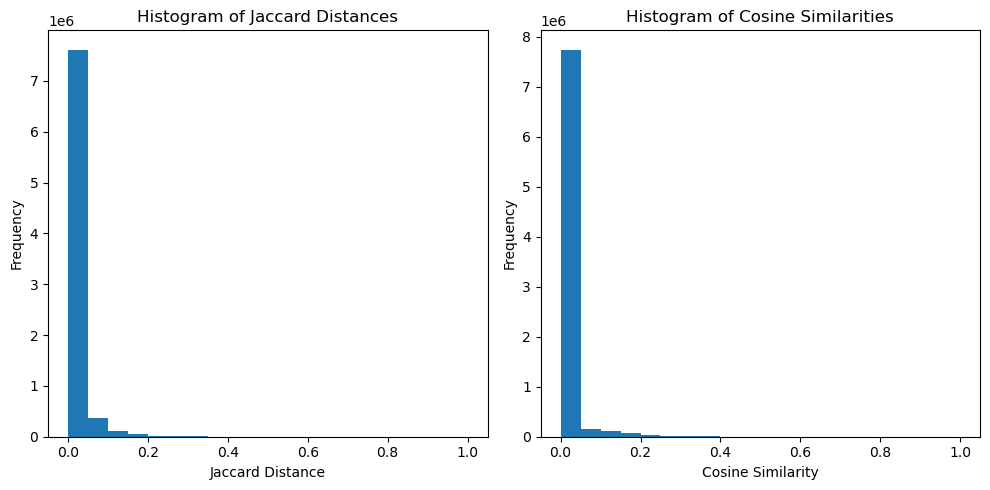

In [142]:
# Flatten the distance matrices and remove self-distances (i.e., distance of a tweet to itself)
jaccard_similarities_flat = jaccard_similarities[np.triu_indices(num_tweets, k=1)]
cosine_similarities_flat = cosine_similarity[np.triu_indices(num_tweets, k=1)]

# Plot the histograms
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.hist(jaccard_similarities_flat, bins=20)
plt.xlabel('Jaccard Distance')
plt.ylabel('Frequency')
plt.title('Histogram of Jaccard Distances')

plt.subplot(1, 2, 2)
plt.hist(cosine_similarities_flat, bins=20)
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.title('Histogram of Cosine Similarities')

plt.tight_layout()
plt.show()

## DBSCAN Clustering with Jaccard Similarity

In [143]:
from sklearn.cluster import DBSCAN
# Set the parameters for DBSCAN clustering
eps = 0.3
min_samples = 5

# Create a DBSCAN clustering instance with the Jaccard distance matrix
dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='precomputed')

# Fit the DBSCAN instance to the Jaccard distance matrix
dbscan.fit(jaccard_similarities)

DBSCAN(eps=0.3, metric='precomputed')

In [144]:
cluster_labels = dbscan.labels_
cluster_labels
len(set(cluster_labels))

1

In [145]:
from sklearn.manifold import TSNE

In [146]:
# Assuming 'word_freq_matrix' is already created
binary_matrix = (features > 0).astype(int)
dense_binary_matrix = binary_matrix.toarray()

C:\Users\kvron\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\kvron\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


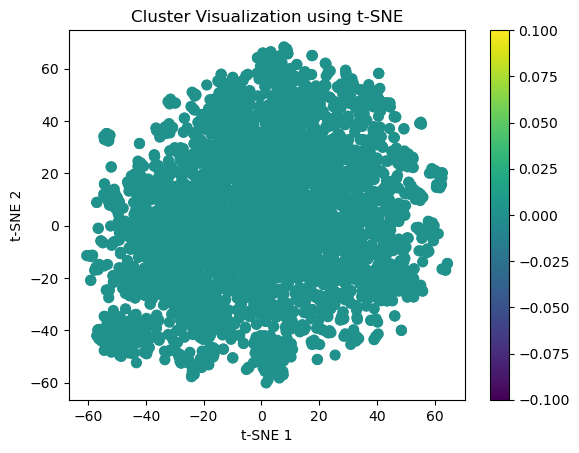

In [147]:
# dense_binary_matrix = binary_matrix.toarray()

tsne = TSNE(n_components=2, metric='cosine', random_state=42, init='random')
reduced_data = tsne.fit_transform(dense_binary_matrix)

plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=cluster_labels, cmap='viridis', marker='o', s=50)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('Cluster Visualization using t-SNE')
plt.colorbar()
plt.show()

## K-Means Clustering with the Cosine Similarity Matrix

In [148]:
kmeans = KMeans()

In [149]:
inertia = []

for i in range(1, 30):
    kmeans = KMeans(n_clusters=i, n_init=10, max_iter=300, random_state=0)
    kmeans.fit(cosine_similarity)
    inertia.append(kmeans.inertia_)

C:\Users\kvron\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=16.
  warnings.warn(


In [150]:
print(inertia)

[27488.72984377276, 26204.653401921398, 25048.39925774107, 24428.690726458386, 24042.648966209574, 23734.02533838538, 23513.940997831854, 23320.355391371177, 22820.189140758717, 22613.14377401053, 22399.284743074866, 22321.41207979752, 22315.93756364537, 22029.94084884808, 21811.435165219584, 21647.019938498008, 21433.479842226843, 21269.37749794907, 21281.885362919267, 21184.728996637736, 20941.21246806891, 20874.865420390266, 20761.16578769529, 20695.598980326027, 20659.46820127954, 20453.44350179569, 20324.286596714355, 20269.632022560727, 20170.087352376813]


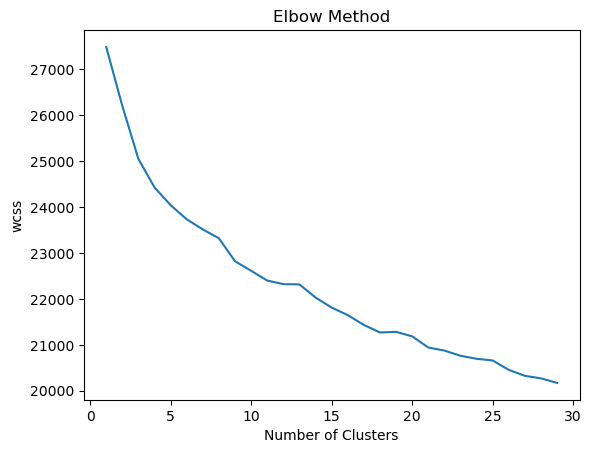

In [151]:
plt.plot(range(1,30), inertia)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('wcss')
plt.show()

In [152]:
kmeans = KMeans(n_clusters=8, n_init=10, max_iter=300, random_state=0)
output = kmeans.fit_predict(cosine_similarity)
cluster_ids, cluster_sizes = np.unique(kmeans.labels_, return_counts=True)
print(cluster_sizes)

[ 118   76  520 2649  120  231  170  161]


C:\Users\kvron\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\kvron\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


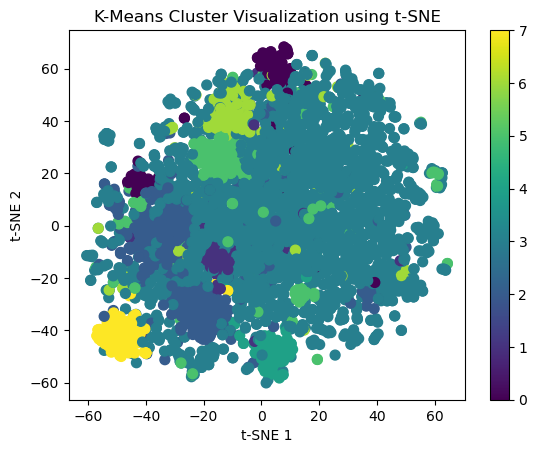

In [153]:
dense_binary_matrix = binary_matrix.toarray()

tsne = TSNE(n_components=2, metric='cosine', random_state=42, init='random')
reduced_data = tsne.fit_transform(dense_binary_matrix)

plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=kmeans.labels_, cmap='viridis', marker='o', s=50)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('K-Means Cluster Visualization using t-SNE')
plt.colorbar()
plt.show()

In [160]:
terms = getMostCommonTerms(tweetVectorDataFrame, kmeans.labels_, 7);

In [161]:
print(terms)

tip               43.691000
getfit            40.700939
today             39.503463
don                6.963409
eat                5.862737
calories           4.722403
shape_magazine     4.437867
day                3.949081
eating             3.567306
readers            3.064312
Name: 7, dtype: float64
